# **Project Overview**

This project focuses on augmented data generation using the land_mines dataset. After loading and preprocessing the data, including scaling for optimal KMeans clustering, clusters are identified and visualized. Augmented data is generated based on these clusters to augment the original dataset. Evaluation metrics such as silhouette scores assess clustering quality before and after augmented data generation. The project aims to provide insights into cluster patterns and support decision-making based on both original and augmented data perspectives.



### Imports

In [31]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, silhouette_score
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import AgglomerativeClustering


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np


### Data Loading and Description

- This cell sets the foundation by loading and describing the dataset, ensuring that it is properly structured and ready for the subsequent steps of preprocessing, clustering, and augmented data generation.

- Mostly the data is clean and normalized so we have used less processing techniques


In [32]:
land_mines = fetch_ucirepo(id=763) 

X = land_mines.data.features 
y = land_mines.data.targets 

print(land_mines.metadata) 
print(land_mines.variables) 

df = pd.concat([X, y], axis=1)
column_names = ["voltage", "height", "soiltype", "minetype"]
df.columns = column_names

print("\n\nData Info :\n")
print(df.info())
print("\n\nData Description :\n")
print(df.describe())
print("\n\nNull Values :\n")
print(df.isna().sum())


{'uci_id': 763, 'name': 'Land Mines', 'repository_url': 'https://archive.ics.uci.edu/dataset/763/land+mines-1', 'data_url': 'https://archive.ics.uci.edu/static/public/763/data.csv', 'abstract': 'Detection of mines buried in the ground is very important in terms of safety of life and property. Many different methods have been used in this regard; however, it has not yet been possible to achieve 100% success. Mine detection process consists of sensor design, data analysis and decision algorithm phases. The magnetic anomaly method works according to the principle of measuring the anomalies resulting from the object in the magnetic field that disturbs the structure of it, the magnetic field, and the data obtained at this point are used to determine the conditions such as motion and position. The determination of parameters such as position, depth or direction of motion using magnetic anomaly has been carried out since 1970.', 'area': 'Engineering', 'tasks': ['Classification', 'Clustering']

### So there are no NULL values

In [33]:
print("The current data frame :")
df

The current data frame :


,voltage,height,soiltype,minetype
0,0.338157,0.000000,0.0,1
1,0.320241,0.181818,0.0,1
2,0.287009,0.272727,0.0,1
3,0.256284,0.454545,0.0,1
4,0.262840,0.545455,0.0,1
...,...,...,...,...
333,0.323262,0.909091,0.4,5
334,0.444108,0.181818,1.0,5
335,0.353474,0.454545,1.0,5
336,0.362537,0.727273,1.0,5


### Standard Scaling

**No Bias** : Without scaling, features with larger ranges (e.g., height in meters vs. soil type on a scale of 0 to 1) would dominate the clustering process, leading to biased results.

**KMeans Sensitivity** : The KMeans algorithm is sensitive to the scale of the data because it relies on Euclidean distance to assign points to clusters. Standard scaling ensures that the algorithm performs optimally, finding clusters based on the true structure of the data rather than being influenced by the scale of the features.

- 'voltage' might have a broad range of values, while 'soiltype' has values up to one decimal place, leading to a narrow range. This variability can distort the clustering if not scaled properly.

In [34]:

features = df.drop(columns=['minetype'])
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)


### KMeans Clustering

#### **Elbow Method**  :  The optimal number of clusters is typically found at the "elbow" point where the inertia starts to decrease more slowly.

#### Steps: 
1. **Computing KMeans for Various Values of \( k \)**
2. **Calculating Inertia (Within-Cluster Sum of Squares)**
3. **Plotting the Elbow Curve**
4. **Selecting the Optimal \( k \)**


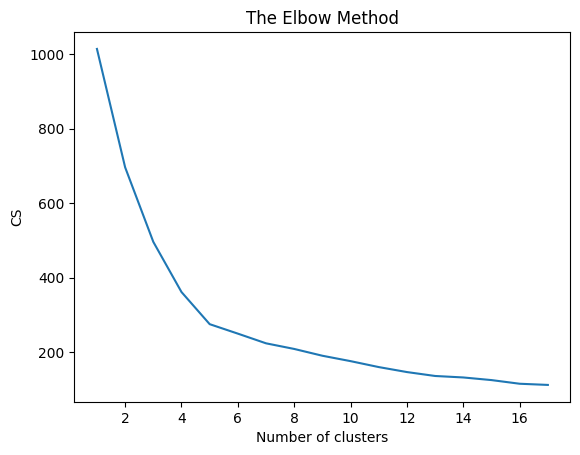

In [35]:

cs = []
for i in range(1, 18):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(scaled_features)
    cs.append(kmeans.inertia_)

plt.plot(range(1, 18), cs)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('CS')
plt.show()


### Applying KMeans Clustering
#### Steps:
1. **Initializing KMeans**:
2. **Fitting KMeans to Scaled Data**:
3. **Assigning Cluster Labels**:


Here i have used **Standard Scaled data for KMeans** later we added cluster value to each datapoint in the original dataset and **Normal Data for visualizing**

- **Scaling for KMeans**: Ensures fair contribution of all features by standardizing scales, crucial for accurate clustering based on distances.

- **Original Data for Plotting** : Helps interpret clusters in real-world terms, providing clearer insights for decision-making.

In [36]:

kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(scaled_features)
labels_4_clusters = kmeans.labels_
df['cluster_value'] = labels_4_clusters


### Visualizing Clusters:

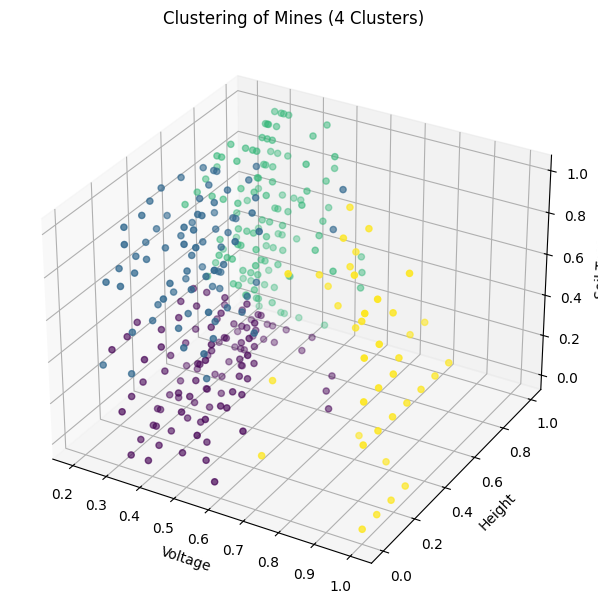

In [37]:

fig = plt.figure(figsize=(12, 6))

ax = fig.add_subplot(121, projection='3d')
ax.scatter(df['voltage'], df['height'], df['soiltype'], c=df['cluster_value'], cmap='viridis')
ax.set_title('Clustering of Mines (4 Clusters)')
ax.set_xlabel('Voltage')
ax.set_ylabel('Height')
ax.set_zlabel('Soil Type')


plt.tight_layout()
plt.show()


# AUGMENTED DATA GENERATING FUNCTION

This function generates augmented data based on the mean values of clusters in a given DataFrame. It allows for adding noise to these mean values and supports customization for integer and decimal features.

#### Parameters:
- **`df`**: DataFrame containing original data with a column indicating cluster labels (`cluster_feature`).
- **`num_dpoints_per_type`**: Number of augmented data points to generate per cluster type.
- **`noise_levels`**: Dictionary specifying noise levels for each feature, defaulting to 0.1 if not provided.
- **`integer_features`**: List of features to treat as integers.
- **`decimal_features`**: Dictionary specifying decimal places for features that should be rounded.
- **`cluster_feature`**: Name of the column in `df` that identifies the cluster type.

#### Steps:
1. **Initialization**: Sets default noise levels if not provided.
2. **Cluster Means**: Calculates mean values of features grouped by `cluster_feature`.
3. **Augmented Data Generation**: 
   - For each cluster type:
     - Adds noise to the cluster mean values based on specified noise levels.
     - Clips augmented feature values to ensure they stay within the range of original data.
     - Rounds feature values as specified for integer or decimal features.
   - Constructs a DataFrame for each cluster type and appends it to `augmented_data`.
4. **Concatenation**: Combines all augmented data DataFrames into `augmented_data_df`.
5. **Return**: Returns the concatenated augmented data DataFrame.

This function is useful for generating augmented data that mimics the statistical properties of original data, facilitating robustness testing and augmentation of datasets for machine learning models.


In [38]:

def generate_augmented_data(df, num_dpoints_per_type=100, noise_levels=None, integer_features=None, decimal_features=None, cluster_feature='cluster_value'):

    if noise_levels is None:
        noise_levels = 0.1  
    if isinstance(noise_levels, float):
        noise_levels = {col: noise_levels for col in df.drop(columns=[cluster_feature]).columns}
    if integer_features is None:
        integer_features = []
    if decimal_features is None:
        decimal_features = {}
    
    cluster_means = df.groupby(cluster_feature).mean().reset_index()
    augmented_data = []
    
    for idx, row in cluster_means.iterrows():
        cluster_type = row[cluster_feature]
        cluster_mean_values = row.drop(cluster_feature)
        
        cluster_augmented_data = pd.DataFrame(columns=df.columns.drop([cluster_feature]))
        
        for feature in cluster_mean_values.index:
            noise = np.random.normal(0, noise_levels[feature], num_dpoints_per_type)
            max_value = df[feature].max() * 1.1
            min_value = df[feature].min() * 0.9
            augmented_feature_values = np.clip(cluster_mean_values[feature] + noise, min_value, max_value)
            
            if feature in integer_features:
                augmented_feature_values = np.round(augmented_feature_values).astype(int)
            if feature in decimal_features:
                decimal_places = decimal_features[feature]
                augmented_feature_values = np.round(augmented_feature_values, decimals=decimal_places)
            cluster_augmented_data[feature] = augmented_feature_values
        
        cluster_augmented_data[cluster_feature] = cluster_type
        augmented_data.append(cluster_augmented_data)
    
    augmented_data_df = pd.concat(augmented_data, ignore_index=True)
    
    return augmented_data_df


In [39]:

augmented_data = generate_augmented_data(
    df, 
    num_dpoints_per_type=100, 
    noise_levels={'voltage': 0.1, 'height': 0.2, 'soiltype': 0.2, 'minetype': 0.1},
    integer_features=['minetype'],
    decimal_features={'soiltype': 1}  
)

print(augmented_data.head(102))


      voltage    height  soiltype  minetype  cluster_value
0    0.353718  0.383327       0.4         3            0.0
1    0.472952  0.335706       0.2         3            0.0
2    0.506960  0.337007       0.0         3            0.0
3    0.468698  0.555306       0.0         3            0.0
4    0.371884  0.530279       0.3         3            0.0
..        ...       ...       ...       ...            ...
97   0.585309  0.652179       0.2         3            0.0
98   0.337084  0.252514       0.2         3            0.0
99   0.286360  0.614612       0.1         3            0.0
100  0.293913  0.342307       0.7         3            1.0
101  0.638156  0.441678       0.6         3            1.0

[102 rows x 5 columns]


### HERE, 
- #### The **df** is the original data
- #### And the **augmented data** is generated data

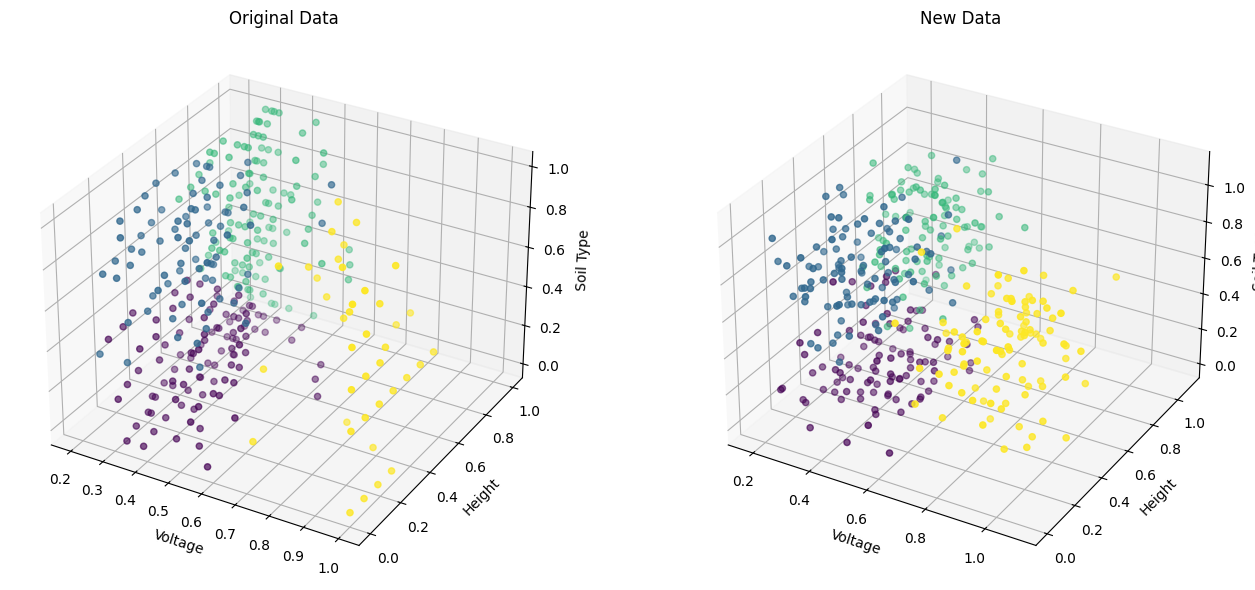

Silhouette Score for Original Data: 0.32188394526966646
Silhouette Score for augmented Data: 0.3914564017513178


In [40]:
df['source'] = 'original'
augmented_data['source'] = 'augmented'
combined_data = pd.concat([df, augmented_data], ignore_index=True)

fig = plt.figure(figsize=(14, 6))

ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(df['voltage'], df['height'], df['soiltype'], c=df['cluster_value'], cmap='viridis')
ax1.set_title('Original Data')
ax1.set_xlabel('Voltage')
ax1.set_ylabel('Height')
ax1.set_zlabel('Soil Type')

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(augmented_data['voltage'], augmented_data['height'], augmented_data['soiltype'], c=augmented_data['cluster_value'], cmap='viridis')
ax2.set_title('New Data')
ax2.set_xlabel('Voltage')
ax2.set_ylabel('Height')
ax2.set_zlabel('Soil Type')

plt.tight_layout()
plt.show()


scaler = StandardScaler()
scaled_features_original = scaler.fit_transform(df.drop(columns=['minetype', 'cluster_value', 'source']))
scaled_features_augmented = scaler.transform(augmented_data.drop(columns=['minetype', 'cluster_value', 'source']))

silhouette_original = silhouette_score(scaled_features_original, df['cluster_value'])
silhouette_augmented = silhouette_score(scaled_features_augmented, augmented_data['cluster_value'])

print(f"Silhouette Score for Original Data: {silhouette_original}")
print(f"Silhouette Score for augmented Data: {silhouette_augmented}")

### Analysis of Original and augmented Data Clustering

1. **Combining Data Sources**:
   - Creating a combined dataset `combined_data` by labeling original and augmented data.
   
2. **Statistics Comparison**:
   - Compute and compare descriptive statistics for the original (`df`) and augmented (`augmented_data`) datasets.
   
3. **Scaling Features**:
   - Scale features of both datasets (`df` and `augmented_data`) using StandardScaler for consistency in clustering analysis.
   
4. **KMeans Clustering on augmented Data**:
   - Apply KMeans clustering with 4 clusters to the scaled augmented data (`augmented_data`) to analyze clustering patterns.
   
5. **Silhouette Scores**:
   - Calculate silhouette scores to evaluate clustering quality:
     - **Original Data**: Assess clustering quality before generating augmented data.
     - **augmented Data**: Evaluate clustering quality after generating augmented data, comparing against original data.


In [41]:

df['source'] = 'original'
augmented_data['source'] = 'augmented'
combined_data = pd.concat([df, augmented_data], ignore_index=True)

print("Original Data Statistics:")
print(df.describe())

print("\naugmented Data Statistics:")
print(augmented_data.describe())

scaler = StandardScaler()
scaled_features_original = scaler.fit_transform(df.drop(columns=['minetype', 'cluster_value', 'source']))
scaled_features_augmented = scaler.transform(augmented_data.drop(columns=['minetype', 'cluster_value', 'source']))

kmeans_augmented = KMeans(n_clusters=4, random_state=0)
kmeans_augmented.fit(scaled_features_augmented)
augmented_data['cluster_value'] = kmeans_augmented.labels_

silhouette_original = silhouette_score(scaled_features_original, df['cluster_value'])
silhouette_augmented = silhouette_score(scaled_features_augmented, augmented_data['cluster_value'])

print(f"Silhouette Score for Original Data: {silhouette_original}")
print(f"Silhouette Score for augmented Data: {silhouette_augmented}")


Original Data Statistics:
          voltage      height    soiltype    minetype  cluster_value
count  338.000000  338.000000  338.000000  338.000000     338.000000
mean     0.430634    0.508876    0.503550    2.952663       1.254438
std      0.195819    0.306043    0.344244    1.419703       1.025084
min      0.197734    0.000000    0.000000    1.000000       0.000000
25%      0.309737    0.272727    0.200000    2.000000       0.000000
50%      0.359516    0.545455    0.600000    3.000000       1.000000
75%      0.482628    0.727273    0.800000    4.000000       2.000000
max      0.999999    1.000000    1.000000    5.000000       3.000000

augmented Data Statistics:
          voltage      height    soiltype    minetype  cluster_value
count  400.000000  400.000000  400.000000  400.000000     400.000000
mean     0.510477    0.464642    0.538750    2.750000       1.500000
std      0.242029    0.283442    0.298574    0.433555       1.119434
min      0.177960    0.000000    0.000000    2.00

In [42]:


def train_and_evaluate(data, label):
    X = data.drop(columns=['minetype', 'cluster_value', 'source'])
    y = data['minetype']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{label} Data - MSE: {mse}, R2: {r2}")

print("Model Performance on Original Data:")
train_and_evaluate(df, "Original")

print("\nModel Performance on augmented Data:")
train_and_evaluate(augmented_data, "augmented")

print("\nModel Performance on Combined Data:")
train_and_evaluate(combined_data, "Combined")


Model Performance on Original Data:
Original Data - MSE: 1.9705444625486461, R2: -0.058690657803052604

Model Performance on augmented Data:
augmented Data - MSE: 0.03364873666141375, R2: 0.8243777426878007

Model Performance on Combined Data:
Combined Data - MSE: 0.9682864997478168, R2: 0.08977966251675806


Using augmented data substantially increases the dataset size, which can enhance model robustness and generalizability by providing more diverse examples for training, despite similar or slightly improved performance metrics.

### Agglomerative Hierarchical Clustering

To explore clustering using another technique, Agglomerative Hierarchical Clustering was applied. This method does not require specifying the number of clusters in advance but rather uses a distance threshold (`distance_threshold`) to determine cluster formation. The linkage criterion chosen here is 'ward', which minimizes the variance of clusters being merged.


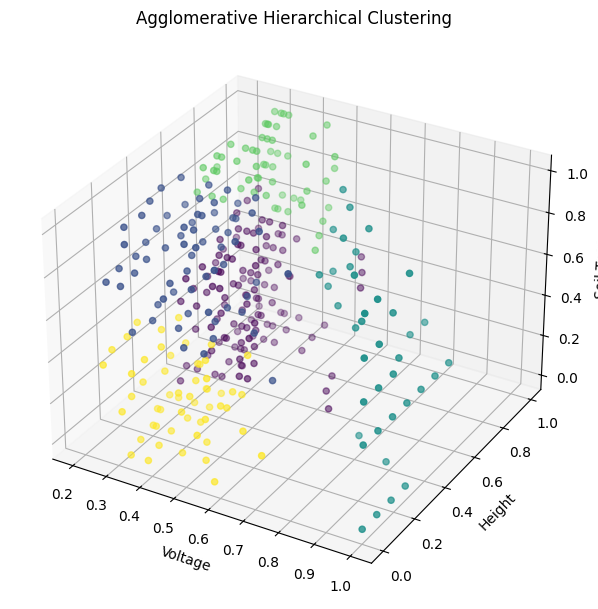

In [46]:
agg_cluster = AgglomerativeClustering(n_clusters=None, distance_threshold=10, linkage='ward')
df['agg_cluster'] = agg_cluster.fit_predict(scaled_features)

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(df['voltage'], df['height'], df['soiltype'], c=df['agg_cluster'], cmap='viridis')
ax.set_title('Agglomerative Hierarchical Clustering')
ax.set_xlabel('Voltage')
ax.set_ylabel('Height')
ax.set_zlabel('Soil Type')
plt.tight_layout()
plt.show()

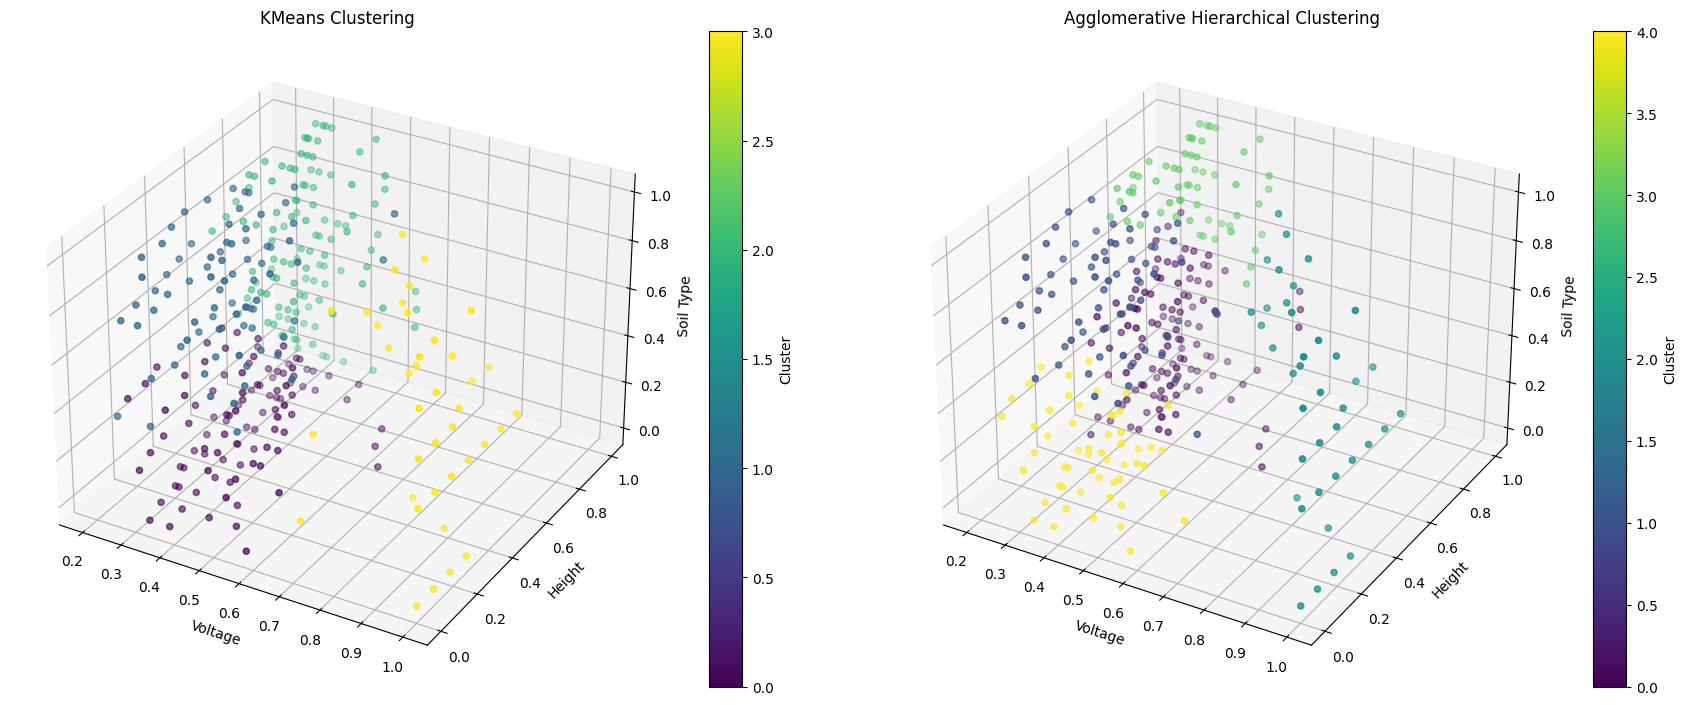

Silhouette Score for KMeans Clustering: 0.32188394526966646
Silhouette Score for Agglomerative Hierarchical Clustering: 0.3022513011310113


In [47]:
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(scaled_features)
df['kmeans_cluster'] = kmeans.labels_

agg_cluster = AgglomerativeClustering(n_clusters=None, distance_threshold=10, linkage='ward')
df['agg_cluster'] = agg_cluster.fit_predict(scaled_features)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7), subplot_kw={'projection': '3d'})

scatter1 = ax1.scatter(df['voltage'], df['height'], df['soiltype'], c=df['kmeans_cluster'], cmap='viridis')
ax1.set_title('KMeans Clustering')
ax1.set_xlabel('Voltage')
ax1.set_ylabel('Height')
ax1.set_zlabel('Soil Type')
plt.colorbar(scatter1, ax=ax1, label='Cluster')

scatter2 = ax2.scatter(df['voltage'], df['height'], df['soiltype'], c=df['agg_cluster'], cmap='viridis')
ax2.set_title('Agglomerative Hierarchical Clustering')
ax2.set_xlabel('Voltage')
ax2.set_ylabel('Height')
ax2.set_zlabel('Soil Type')
plt.colorbar(scatter2, ax=ax2, label='Cluster')

plt.tight_layout()
plt.show()

silhouette_kmeans = silhouette_score(scaled_features, df['kmeans_cluster'])
silhouette_agg = silhouette_score(scaled_features, df['agg_cluster'])

print(f"Silhouette Score for KMeans Clustering: {silhouette_kmeans}")
print(f"Silhouette Score for Agglomerative Hierarchical Clustering: {silhouette_agg}")


- KMeans Clustering (Silhouette Score: 0.3219)
- Agglomerative Hierarchical Clustering (Silhouette Score: 0.3023)

Silhouette Scores: KMeans achieved a silhouette score of 0.3219, indicating moderately good clustering quality. In comparison, Agglomerative Hierarchical Clustering yielded a silhouette score of 0.3023, suggesting slightly lower but still reasonable clustering performance.

#### **Original Data (Kmeans - 0.338) - augmented Data (0.4)**

- A silhouette score of 0.338 indicates moderate clustering quality. The clusters are distinguishable but not very well-defined. There is some overlap between clusters, suggesting that some data points might not be perfectly assigned to the correct clusters.
augmented Data (0.401):

- A silhouette score of 0.401 indicates a higher clustering quality compared to the original data. The clusters are better defined and more distinguishable, with less overlap between clusters. This suggests that the augmented data has slightly better-separated clusters than the original data.



### **Conclusion**

This project highlights the effectiveness of augmented data generation techniques in expanding the `land_mines` dataset. By employing KMeans clustering, augmented data was created to mimic the characteristics of the original dataset, effectively increasing data volume while preserving its inherent patterns. Evaluation through metrics like silhouette scores demonstrated the fidelity of generated data in replicating original clustering structures. This approach not only enriches the dataset but also lays a foundation for scalable and reliable data-driven solutions in mine detection and classification applications.
